# Implementation of the Eigenface Method

## Set up

In [127]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [226]:
# load data
import sklearn.datasets

min_faces_per_person=50
resize = 0.5
color = False

# TODO: confirm whether there is a data leakage issue here
print('Downloading training set...')
dataset_train = sklearn.datasets.fetch_lfw_people(color=color, resize=resize)
print('Done.')

print('Downloading testing set...')
dataset_test = sklearn.datasets.fetch_lfw_pairs(subset='test', color=color, resize=resize)
print('Done.\n\n')

n_train_samples, h, w = dataset_train.images.shape
n_features = h*w

X_train = dataset_train.data
y_train = dataset_train.target
y_dict = dataset_train.target_names

test_pairs = dataset_test.pairs
y_test = dataset_test.target
n_test_pairs = len(test_pairs)

print('# of training images: ', n_train_samples)
print(f'image resolution: {w}x{h}')
print(f'# of face identities: ', len(y_dict))
print('# of testing image pairs', n_test_pairs)

# of training images:  13233
image resolution: 47x62
# of face identities:  5749
# of testing image pairs 1000


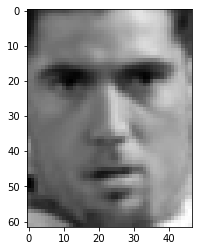

In [228]:
# show a random image sample
sample_img = dataset_train.images[np.random.choice(range(n_train_samples))]
plt.imshow(sample_img, cmap='gray')

## Pre-Processing

In [229]:
# # Train-Test Split
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)


# Normalize
normalizer = StandardScaler().fit(X_train)
X_train_transformed = normalizer.transform(X_train)

## Find Principle Components

In [230]:
# number of components to keep
n_components = 50

pca = PCA(n_components=n_components, svd_solver="auto", whiten=False).fit(X_train_transformed)

eigenfaces = pca.components_.reshape((n_components, h, w))

print(f'Explained Variance: {sum(pca.explained_variance_ratio_)} (with {n_components} components)')

Explained Variance: 0.8415420565288514 (with 50 components)


In [ ]:
# TODO: plot explained variance against n_components

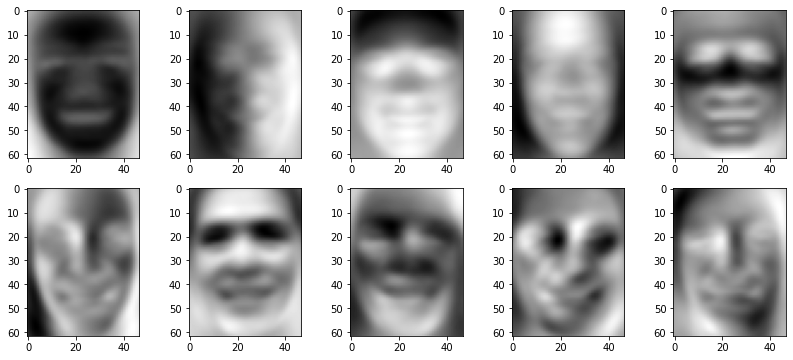

In [232]:
# plot top eigenfaces

n_plots = 10
fig, axs = plt.subplots(figsize=(14, 6), ncols=n_plots//2, nrows=2)
for ax, eigenface in zip(axs.flat, eigenfaces):
    ax.imshow(eigenface, cmap='gray')

In [233]:
# TODO: exclude first 3 components
# TODO: experiment w/ number of components
# TODO: ...

## Modeling: Eigenface

In [251]:
eps_default = 60.34
def eigenface_classifier(face1, face2, eps=eps_default, normalized=False, vectorized=False):
    '''simple threshold as proposed in eigenface paper'''

    # # flatten images into R^n vectiors
    if not vectorized:
        face1 = face1.flatten()
        face2 = face2.flatten()

    if not normalized:
        face1, face2 = normalizer.transform([face1, face2])

    # compute the eigenface projections of each face image
    face1_projection, face2_projection = pca.transform([face1, face2])
    # print(face1_projection)

    # compute the distance between the two projections
    dist = np.linalg.norm(face1_projection - face2_projection, ord=2)

    return dist < eps

In [252]:
test_pairs.shape

(1000, 2, 62, 47)

In [256]:
def compute_acc(clf, params):
    preds = [clf(x1, x2, vectorized=False, **params) for (x1, x2) in test_pairs]
    acc = sklearn.metrics.accuracy_score(preds, y_test)
    return acc

In [260]:
compute_acc(eigenface_classifier, {'eps': 200})

0.5

### try to find the optimal threshold value...

In [ ]:
# # maximize accuracy func w.r.t threshold using scipy.optimize
# # doesn't seem to be working... (just returns x_0)
# import scipy.optimize
# to_optimize = lambda eps: -compute_acc(eigenface_classifier, {'eps': eps})
# scipy.optimize.minimize(to_optimize, 55)

      fun: -0.642
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([55.])

In [282]:
# try a bunch of values and see what we get...
eps_try = np.linspace(0, 100, num=100)
accs = [compute_acc(eigenface_classifier, {'eps': eps}) for eps in eps_try]

In [288]:
# hone in on the most promising range
eps_crit = eps_try[np.argmax(accs)]
eps_try = np.linspace(eps_crit - 1, eps_crit + 1, num=50)
accs = [compute_acc(eigenface_classifier, {'eps': eps}) for eps in eps_try]

In [289]:
eps_crit = eps_try[np.argmax(accs)]
max_acc = np.max(accs)

print(f'achieved an accuracy of {max_acc} using a threshold of {eps_crit}')

achieved an accuracy of 0.644 using a threshold of 60.34075448361163
